In [1]:
use_udacity_workspace = True

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

### Download and lyaout files

If local notebook instead of Udacity workspace:

In [2]:
import os

if not use_udacity_workspace:
    if not os.path.exists("dog_images"):
        print("Download Dog Images dataset...")
        !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
        !unzip dogImages.zip
        !rm -f dogImages.zip
        !mv dogImages dog_images

    if not os.path.exists("lfw"):
        print("Download Human dataset...")
        !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
        !unzip lfw.zip
        !rm -f lfw.zip

### Import Datasets

In [4]:
import numpy as np
from glob import glob

# load filenames for human and dog images
data_path_prefix = "/data/" if use_udacity_workspace else ""

human_files = np.array(glob(f"{data_path_prefix}lfw/*/*"))
dog_files = np.array(glob(f"{data_path_prefix}dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images ([up-to-date link](https://docs.opencv.org/trunk/db/d28/tutorial_cascade_classifier.html)).  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


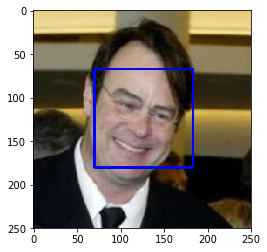

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

def highlight_faces(img_path):
    # load color (BGR) image
    img = cv2.imread(img_path)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
    
highlight_faces(human_files[0])

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

* First 100 images of `human_files` - `98%` human faces
* First 100 images of `dog_files` - `17%` human faces

In [7]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

In [8]:
import sys

def check_detector(title_prefix, paths, detector_fun):
    n = len(paths)

    # Detected counter
    detectected_cnt = 0

    sys.stdout.flush()
    sys.stderr.flush()
    
    for path in tqdm(paths):
        detectected_cnt += int(detector_fun(path))

    sys.stdout.flush()
    sys.stderr.flush()
    print(f"{title_prefix} detected in {detectected_cnt / n:.1%} samples ({detectected_cnt} of {n})")

In [9]:
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

print("Testing first 100 Human faces...")
check_detector("Human faces", human_files_short, face_detector)

print("------------")

print("Testing first 100 Dog images...")
check_detector("Human faces", dog_files_short, face_detector)

Testing first 100 Human faces...


100%|██████████| 100/100 [00:02<00:00, 35.03it/s]


Human faces detected in 98.0% samples (98 of 100)
------------
Testing first 100 Dog images...


100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


Human faces detected in 17.0% samples (17 of 100)


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

### (Optional): Human faces VGG16 predictor

In [10]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

Let's try to detect human faces using transfer learning and VGG16 Network.

This is not honest face detector, because I'm using transfer learning to train it to differ dogs and humans, obviously we need more than 2 categories, otherwise the model won't cover the case when there is neither human nor dog on the image. But I realized this only after I've implemented and trained the model. So I'm leaving it here, it was a good excercise. Also data augmentation will be usefull for training.

I didn't used first 100 human and dog images, so they are pure validation. Other data was split in test and train set.

I've strarted with 3000 random images where test set is 10%, trained this for 20 epochs and good 100% accuracy on test and validation set (model `model_human_detector_gpu_small.pt`). Then I decide to use this model params as new defaults and re-train model in all dataset (except first 100 dogs and humans, ~21.000 images, 20% test set), I did it for 4 epochs (works rather slow) and got 100% accuracy on 4276 test images and our validation (100+100) dataset (model `model_human_detector_gpu_big.pt`). Not sure that I'll manage to submit these models due to submissions files limitation (each model ~500 mb).

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

* First 100 images of `human_files` - `100%` human faces
* First 100 images of `dog_files` - `0%` human faces

P.S: CV face detector is more honest (not limited to our dogs & humans dataset) and works faster.

Here is source code form transfer learning and making such 'human' detector.

In [11]:
from torchvision import transforms

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_image(img_path, max_size=400, shape=(224, 224)):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    

    try:
        image = Image.open(img_path).convert('RGB')
    except OSError as e:
        print("Cannot load:", img_path)
        raise e
        
    in_transform = transforms.Compose([
        transforms.Resize(shape),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
        )
    ])

    # discard the transparent, alpha channel (that's the :3)
    return in_transform(image)[:3,:,:]

In [12]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy() #.squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

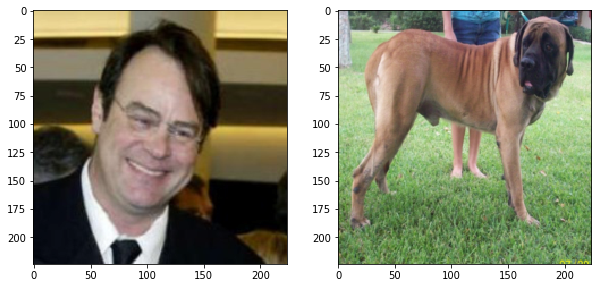

In [13]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# content and style ims side-by-side
ax1.imshow(im_convert(load_image(human_files[0])))
ax2.imshow(im_convert(load_image(dog_files[0])))

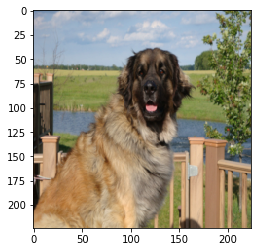

In [15]:
# Check image with "truncated" file
plt.imshow(im_convert(load_image(f"{'/data/' if use_udacity_workspace else ''}dog_images/train/098.Leonberger/Leonberger_06571.jpg")))

Reserve first 100 dogs and humans for test. 

In [16]:
human_files_train = human_files[100:]
dog_files_train = dog_files[100:]

print("Humans: ", len(human_files_train))
print("Dogs: ", len(dog_files_train))

Humans:  13133
Dogs:  8251


Assign lables for Dog and Humans

In [17]:
all_files = np.concatenate([human_files_train, dog_files_train])

classes = {
    0: "Dog",
    1: "Human"
}
all_labels = np.concatenate([np.ones(len(human_files_train), dtype=np.long), np.zeros(len(dog_files_train), dtype=np.byte)])

print("All files:", len(all_files))

All files: 21384


Split data in train and validation sets. At the moment we have too much images for my laptop, let's use only first random 3000 images of dataset.

In [18]:
np.random.seed(100)

indices = list(range(len(all_files)))
np.random.shuffle(indices)

# to many imgs for my computer, let's take first 3000
indices = indices[0:3000]

test_size = 0.1 # to many imgs for my computer, should be 0.22 here

split = int(np.floor(test_size * len(indices)))
train_idx, valid_idx = indices[split:], indices[:split]

print("Train: ", len(train_idx))
print("Validation: ", len(valid_idx))

Train:  2700
Validation:  300


In [19]:
train_data = [(load_image(all_files[i]), all_labels[i]) for i in train_idx]
valid_data = [(load_image(all_files[i]), all_labels[i]) for i in valid_idx]

In [20]:
import torch

# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True
)

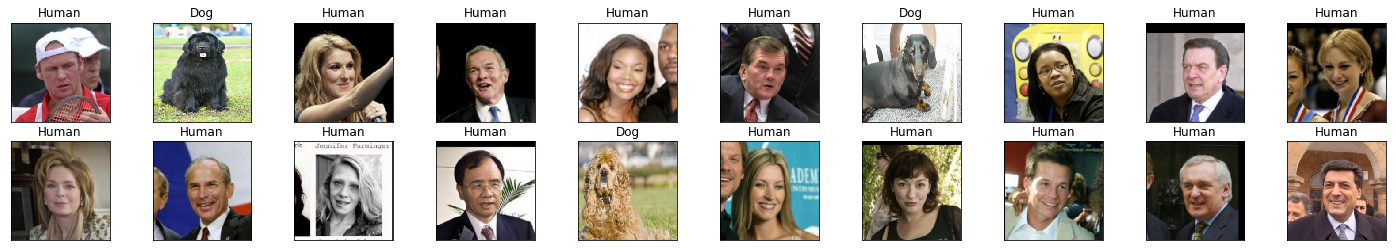

In [21]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [22]:
import torch

use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
    device='cpu'
else:
    print('CUDA is available!  Training on GPU ...')
    device='cuda'

CUDA is available!  Training on GPU ...


In [23]:
import torchvision.models as models

# define VGG16 model
model_for_detector = models.vgg16(pretrained=True).to(device)


# print out the model structure
print(model_for_detector)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 91090198.98it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [24]:
print(model_for_detector.classifier[6].in_features) 
print(model_for_detector.classifier[6].out_features) 

4096
1000


In [25]:
# Freeze training for all "features" layers
for param in model_for_detector.features.parameters():
    param.requires_grad = False

Final classifier layer

In [26]:
import torch.nn as nn

n_inputs = model_for_detector.classifier[6].in_features

# add last linear layer (n_inputs -> 2 classes)
# new layers automatically have requires_grad = True
model_for_detector.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 250),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(250, 2),
    nn.LogSoftmax(dim=1)
)


# if GPU is available, move the model to GPU
model_for_detector = model_for_detector.to(device)

# check to see that your last layer produces the expected number of outputs
print(model_for_detector.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=250, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=250, out_features=2, bias=True)
  (4): LogSoftmax()
)


Loss function

In [27]:
import torch.optim as optim

# specify loss function
criterion = nn.NLLLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model_for_detector.classifier.parameters(), lr=0.001)
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

In [28]:
!mkdir -p 'additional_files'

In [29]:
model = model_for_detector
model_path = 'additional_files/model_human_detector_gpu_small.pt'
# model_path = 'model_human_detector_tmp.pt'

In [30]:
n_epochs = 20  # number of epochs to train the model
print_every = 2   # Print loss every <print_every> mini batches


valid_loss_min = np.Inf # track change in test loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    train_loss_latest = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.to(device), target.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss 
        loss_value = loss.item()
        train_loss_latest += loss_value
        train_loss += loss_value * data.size(0)
        
        if batch_i % print_every == (print_every - 1):    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss_latest / print_every))
            train_loss_latest = 0.0
            
        if batch_i > print_every:
            break
    
            
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.to(device), target.to(device)
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), model_path)
        valid_loss_min = valid_loss

Epoch 1, Batch 2 loss: 0.7218049764633179
Epoch 1, Batch 4 loss: 0.6532858610153198
Epoch: 1 	Training Loss: 0.020372 	Validation Loss: 0.654738
Validation loss decreased (inf --> 0.654738). Saving model ...
Epoch 2, Batch 2 loss: 0.6688205301761627
Epoch 2, Batch 4 loss: 0.7115697860717773
Epoch: 2 	Training Loss: 0.020450 	Validation Loss: 0.624481
Validation loss decreased (0.654738 --> 0.624481). Saving model ...
Epoch 3, Batch 2 loss: 0.6481847763061523
Epoch 3, Batch 4 loss: 0.6960132122039795
Epoch: 3 	Training Loss: 0.019914 	Validation Loss: 0.599840
Validation loss decreased (0.624481 --> 0.599840). Saving model ...
Epoch 4, Batch 2 loss: 0.6523292064666748
Epoch 4, Batch 4 loss: 0.6039328873157501
Epoch: 4 	Training Loss: 0.018611 	Validation Loss: 0.576983
Validation loss decreased (0.599840 --> 0.576983). Saving model ...
Epoch 5, Batch 2 loss: 0.5769318640232086
Epoch 5, Batch 4 loss: 0.5570324361324310
Epoch: 5 	Training Loss: 0.016799 	Validation Loss: 0.553622
Validati

I've trained the model on GPU, let's load it and check how accurate is our human/dog detector.
Requirements for notebook submissions is to make it less than 500 MB uncompressed, so I cannot attach my model (it is ~512 mb)

In [31]:
map_kw = dict() if use_cuda else dict(map_location=torch.device('cpu'))
model.load_state_dict(torch.load('additional_files/model_human_detector_gpu_small.pt', **map_kw))
# model.load_state_dict(torch.load('additional_files/model_human_detector_gpu_big.pt', **map_kw))

In [34]:
# returns "True" if face is detected in image stored at img_path
def face_detector_cnn(img_path, model):
    data = load_image(img_path).unsqueeze(0)
    if use_cuda:
        data = data.cuda()
    output = model(data)
    _, pred = torch.max(output, 1)
    return pred.item() == 1

In [35]:
print("Check that detection works")
print("Some Human image -> human face: ", face_detector_cnn(human_files[0], model))
print("Some Dog image -> human face: ", face_detector_cnn(dog_files[0], model))

Check that detection works
Some Human image -> human face:  True
Some Dog image -> human face:  False


In [36]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#
import sys

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

print("Testing first 100 Human faces...")
check_detector("Human faces", human_files_short, lambda p: face_detector_cnn(p, model))

print("------------")

print("Testing first 100 Dog images...")
check_detector("Human faces", dog_files_short, lambda p: face_detector_cnn(p, model))

Testing first 100 Human faces...


100%|██████████| 100/100 [00:03<00:00, 30.13it/s]


Human faces detected in 100.0% samples (100 of 100)
------------
Testing first 100 Dog images...


100%|██████████| 100/100 [00:04<00:00, 22.02it/s]


Human faces detected in 0.0% samples (0 of 100)


This detector is rather slow.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [37]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [38]:
import torchvision.transforms as transforms

from PIL import Image
from PIL import ImageFile
# Set PIL to be tolerant of image files that are truncated.
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_image(img_path):
    '''
    Args:
        img_path: path to an image
        
    Returns:
        Tensor that can be used as VGG-16 model input
    '''
    
    try:
        image = Image.open(img_path).convert('RGB')
    except OSError as e:
        print("Cannot load:", img_path)
        raise e
        
    # VGG16 expects 224x224 images, let's resize automatically
    in_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406), 
            (0.229, 0.224, 0.225))
    ])
      
        
    # discard the transparent, alpha channel (that's the :3)
    return in_transform(image)[:3,:,:]

In [46]:
def classification_model_predict(tensor, model):
    '''
    Obtain image class from model for image at specified path
    
    Args:
        tensor: Image preprocessed for model to be used as input
        
    Returns:
        Index corresponding to category class
    '''
    with torch.no_grad():
        input = tensor.unsqueeze(0)
        if use_cuda:
            input = input.cuda()
            
        output = model(input)

        # predicted class index
        _, pred = torch.max(output, 1)
        return pred.item()
    
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## Load and pre-process an image from the given img_path
    image = load_image(img_path)
    
    ## Return the *index* of the predicted class for that image
    return classification_model_predict(image, VGG16)

In [47]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy() #.squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

Ensure prediction works:

In [48]:
from additional_files.imgnet_cls_ids import IMAGENET_1000_CLS_IDX_2_LABELS

Class:  255 , image net label: Leonberg


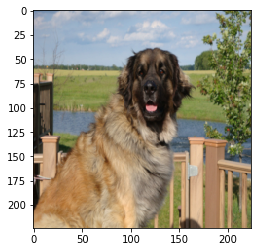

In [49]:
image_path = f"{'/data/' if use_udacity_workspace else ''}dog_images/train/098.Leonberger/Leonberger_06571.jpg"
plt.imshow(im_convert(load_image(image_path)))

cls_id = VGG16_predict(image_path)
print("Class: ", cls_id, ", image net label:", IMAGENET_1000_CLS_IDX_2_LABELS[cls_id])

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [50]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, class_predictor_fun=VGG16_predict):
    cls_id = class_predictor_fun(img_path)
    return 151 <= cls_id <= 268

Let's check how detector works for several examples:

/data/dog_images/train/098.Leonberger/Leonberger_06571.jpg is dog: True (class: 255, label: Leonberg)


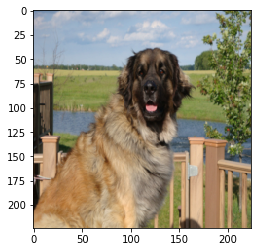

/data/dog_images/train/048.Chihuahua/Chihuahua_03398.jpg is dog: True (class: 151, label: Chihuahua)


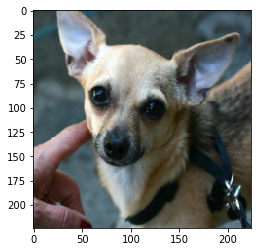

/data/lfw/AJ_Cook/AJ_Cook_0001.jpg is dog: False (class: 785, label: seat belt, seatbelt)


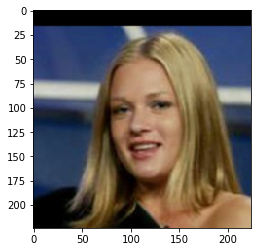

/data/lfw/Woody_Allen/Woody_Allen_0001.jpg is dog: False (class: 906, label: Windsor tie)


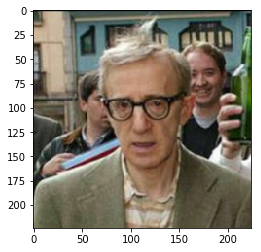

In [53]:
for p in [
    "dog_images/train/098.Leonberger/Leonberger_06571.jpg",
    "dog_images/train/048.Chihuahua/Chihuahua_03398.jpg",
    "lfw/AJ_Cook/AJ_Cook_0001.jpg",
    "lfw/Woody_Allen/Woody_Allen_0001.jpg"
]:
    p = ('/data/' if use_udacity_workspace else '') + p
    is_dog = dog_detector(p)
    cls_id = VGG16_predict(p)
    print(f"{p} is dog: {is_dog} (class: {cls_id}, label: {IMAGENET_1000_CLS_IDX_2_LABELS[cls_id]})")
    plt.imshow(im_convert(load_image(p)))
    plt.show()

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__
- `human_files_short` - 1% detected as dog
- `dog_files_short` - 100% detected as dog

See details:

In [54]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#
import sys

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

print("Testing first 100 Human faces...")
check_detector("Dogs", human_files_short, dog_detector)

print("------------")

print("Testing first 100 Dog images...")
check_detector("Dogs", dog_files_short, dog_detector)

Testing first 100 Human faces...


100%|██████████| 100/100 [00:03<00:00, 30.17it/s]


Dogs detected in 1.0% samples (1 of 100)
------------
Testing first 100 Dog images...


100%|██████████| 100/100 [00:04<00:00, 22.02it/s]


Dogs detected in 100.0% samples (100 of 100)


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

__Optional Question:__

Report the performance of another pre-trained network.
Feel free to use as many code cells as needed.

__Answer:__

When launched using Udacity workspace, Inception-v3 model fails with some internal error. 

* ResNet-50:
    - `human_files_short` - 0% detected as dog
    - `dog_files_short` - 100% detected as dog

My local run works ok, results were:
* Inception-v3:
    - `human_files_short` - 2% detected as dog
    - `dog_files_short` - 96% detected as dog

* ResNet-50:
    - `human_files_short` - 0% detected as dog
    - `dog_files_short` - 96% detected as dog


In [57]:
### (Optional)

import sys

import torch
import torchvision.models as models

from tqdm import tqdm

# define VGG16 model
ResNet50 = models.resnet50(pretrained=True)
Inception_v3 = models.inception_v3(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# data
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


if use_udacity_workspace:
    alternative_models = [(ResNet50, 'ResNet50')]
else:
    alternative_models = [(ResNet50, 'ResNet50'), (Inception_v3, 'Inception_v3')]
    
for model, model_name in alternative_models:
# for model, model_name in [(Inception_v3, 'Inception_v3')]:
    # move model to GPU if CUDA is available
    if use_cuda:
        model = model.cuda()
    
    model.eval()
    print("Model:", model_name)
    
    class_predictor_fun = lambda img_path: classification_model_predict(load_image(img_path), model)
    detector_fun = lambda img_path: dog_detector(img_path, class_predictor_fun=class_predictor_fun)
    
    print("Testing first 100 Human faces...")
    check_detector("Dogs", human_files_short, detector_fun)

    print("------------")

    print("Testing first 100 Dog images...")
    check_detector("Dogs", dog_files_short, detector_fun)
    
    print("#############")

Model: ResNet50
Testing first 100 Human faces...


100%|██████████| 100/100 [00:02<00:00, 47.62it/s]


Dogs detected in 0.0% samples (0 of 100)
------------
Testing first 100 Dog images...


100%|██████████| 100/100 [00:03<00:00, 29.18it/s]


Dogs detected in 100.0% samples (100 of 100)
#############


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [58]:
import os

import torch
import torchvision.transforms as transforms
from torchvision import datasets

## Data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_dir = ('/data/' if use_udacity_workspace else '') + "dog_images"     

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])


test_valid_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])
])

# Pass transforms in here, then run the next cell to see how the transforms look
data_scratch = {}
data_scratch['train'] = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
data_scratch['valid'] = datasets.ImageFolder(data_dir + '/valid', transform=test_valid_transforms)
data_scratch['test'] = datasets.ImageFolder(data_dir + '/test', transform=test_valid_transforms)

batch_size = 20 # 64?
num_workers = 0

loaders_scratch = {}
loaders_scratch['train'] = torch.utils.data.DataLoader(
    data_scratch['train'], shuffle=True,
    batch_size=batch_size, num_workers=num_workers
)
loaders_scratch['valid'] = torch.utils.data.DataLoader(
    data_scratch['valid'], shuffle=True,
    batch_size=batch_size, num_workers=num_workers
)
loaders_scratch['test'] = torch.utils.data.DataLoader(
    data_scratch['test'],
    batch_size=batch_size, num_workers=num_workers
)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
Train images are randomly croped to 80-100% of its size, streched to aspect ratio 3/4..4/3, then resized to 224. Image size is 224 because it looks to work ok in ImageNet for breed classifying and also it will be easier to reuse these data loaders for transfer learning exercises. Normalization same as ImageNet. I've decedided not to do very strong crop so as not to lose some important details, like dog's head. But some crop could help to make dog a bit more independent of surrounding background.

I augment dataset, allow random flip, and up to 30 degree random rotation. Dogs are often captured in different poses and by different angles, so it seems reasonable to used flip, rotation and stretching. Also we have only 6680 images in train dataset, seems not enough data compared to 14 mln images in ImageNet, so augmentation could help as less overfit.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

Expect breeds number is:

In [59]:
class_names = [item[4:].replace("_", " ") for item in data_scratch['train'].classes]
breeds_number = len(class_names)
print("Breeds number:", breeds_number)

Breeds number: 133


Model

In [60]:
import torch

use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
    device='cpu'
else:
    print('CUDA is available!  Training on GPU ...')
    device='cuda'

CUDA is available!  Training on GPU ...


In [61]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [62]:
import torch.nn as nn
import torch.nn.functional as F

model_scratch = None

# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.features = nn.Sequential(
            # cov_1
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            # 224x224 -> 112 x 112
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # cov_2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            # 112x112 -> 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # cov_3
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            # 56x56 -> 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            #nn.AdaptiveAvgPool2d(7)
        )
        
        n_inputs = 64 * 28 * 28
        # n_inputs = 64 * 7 * 7
        self.classifier =  nn.Sequential(
            nn.Linear(n_inputs, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 133),
        )      
    
    def forward(self, x):
        ## Define forward behavior
        x = self.features.forward(x)
        
        x = Flatten().forward(x)
        x = self.classifier.forward(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
* Reduced number of layers. I started with smth close to VGG16 but there were not enough RAM to init a model. Also we have ~7k dog images, not enough data to train large network, model will overfit. Also I tried model with 2 conv layers before each max pooling layer, but it showed comparable validation error.

* Removed AdaptiveAvgPool2d(7) layer: Without it I get better validation error, so I decided not to use it although many deep models seems to use it. Seems my model isn't deep enough for benifit from it.

* Tried different learning rates near 0.01. Decided to use 0.03 - it allows to get required accuracy and works faster than 0.01. Here is a large field to play with params, seems I don't have enough time before deadline and limited GPU time for course, so I decided to stop with some working solution.

* Current solution has the best validation error near 15 epoch, than validation error increses, test error continue decresing. So I limited with max 20 epoch, just too make the trend noticeable.

* I've tried converting images to gray scaled ones, but didn't get better results.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [63]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
# optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.03)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [64]:
import os

if use_udacity_workspace:
    if not os.path.exists("workspace_utils.py"):
        !wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5b06f6c2_workspace-utils/workspace-utils.py
        !mv workspace-utils.py workspace_utils.py

    from workspace_utils import active_session
    print("Force notebook workspace session active.")
else:
    print("Local notebook mode.")
        
    from contextlib import contextmanager

    # Fake context manager just to have same impl for model training process
    @contextmanager
    def active_session(*args, **kwds):
        yield

Force notebook workspace session active.


In [65]:
# Continue previous training: load model as default values:
# model_scratch.load_state_dict(torch.load('model_scratch.pt'))

In [66]:
import numpy as np

# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            
    # return trained model
    return model

In [67]:
model_scratch_path = 'additional_files/model_scratch_conf3.1_lr0.03.pt'
# model_scratch_path = 'model_scratch_tmp.pt'

In [68]:
# train the model
model_scratch_epochs = 20
with active_session():
    model_scratch = train(
        model_scratch_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
        criterion_scratch, use_cuda, model_scratch_path
    )


Epoch: 1 	Training Loss: 4.825671 	Validation Loss: 4.688561
Validation loss decreased (inf --> 4.688561).  Saving model ...
Epoch: 2 	Training Loss: 4.549080 	Validation Loss: 4.431159
Validation loss decreased (4.688561 --> 4.431159).  Saving model ...
Epoch: 3 	Training Loss: 4.358747 	Validation Loss: 4.347366
Validation loss decreased (4.431159 --> 4.347366).  Saving model ...
Epoch: 4 	Training Loss: 4.244268 	Validation Loss: 4.286779
Validation loss decreased (4.347366 --> 4.286779).  Saving model ...
Epoch: 5 	Training Loss: 4.149567 	Validation Loss: 4.178203
Validation loss decreased (4.286779 --> 4.178203).  Saving model ...
Epoch: 6 	Training Loss: 4.034511 	Validation Loss: 4.138438
Validation loss decreased (4.178203 --> 4.138438).  Saving model ...
Epoch: 7 	Training Loss: 3.933203 	Validation Loss: 4.081917
Validation loss decreased (4.138438 --> 4.081917).  Saving model ...
Epoch: 8 	Training Loss: 3.811443 	Validation Loss: 4.133136
Epoch: 9 	Training Loss: 3.728398 

In [69]:
# load the model that got the best validation accuracy
map_kw = dict() if use_cuda else dict(map_location=torch.device('cpu'))
model_scratch.load_state_dict(torch.load(model_scratch_path, **map_kw))
# model_scratch.load_state_dict(torch.load("additional_files/model_scratch_conf3.1_lr0.03.pt", **map_kw))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [70]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [71]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.902246


Test Accuracy: 13% (110/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [72]:
## Specify data loaders
data_transfer = data_scratch
loaders_transfer = loaders_scratch

class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
breeds_number = len(class_names)
print("Breeds number:", breeds_number)

Breeds number: 133


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [73]:
import torch
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 


# define VGG16 model
model_transfer = models.vgg16(pretrained=True).to(device)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
    
n_inputs = model_transfer.classifier[6].in_features
model_transfer.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, breeds_number),
)
    
if use_cuda:
    model_transfer = model_transfer.cuda()

In [74]:
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
* I replaced last layer of VGG16 classifier with 2 fully connected layers which reduces 4096 features to 512 and than to 133 breads numbers. Also I use Dropout for faster network training and less overfitting. This network provides required accuracy. 
* Most likely we could simplify the network even more and use less layers in whole classifier, but I don't have enough time to play with it.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [75]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [76]:
model_transfer_path = "additional_files/model_transfer.pt"

In [77]:
model_transfer_epochs = 20

# train the model
with active_session():
    model_transfer = train(
        model_transfer_epochs, loaders_transfer, model_transfer,
        optimizer_transfer, criterion_transfer, use_cuda, 
        model_transfer_path
    )

Epoch: 1 	Training Loss: 2.459806 	Validation Loss: 0.783952
Validation loss decreased (inf --> 0.783952).  Saving model ...
Epoch: 2 	Training Loss: 0.892594 	Validation Loss: 0.605673
Validation loss decreased (0.783952 --> 0.605673).  Saving model ...
Epoch: 3 	Training Loss: 0.676359 	Validation Loss: 0.524894
Validation loss decreased (0.605673 --> 0.524894).  Saving model ...
Epoch: 4 	Training Loss: 0.570209 	Validation Loss: 0.468394
Validation loss decreased (0.524894 --> 0.468394).  Saving model ...
Epoch: 5 	Training Loss: 0.492739 	Validation Loss: 0.430708
Validation loss decreased (0.468394 --> 0.430708).  Saving model ...
Epoch: 6 	Training Loss: 0.449616 	Validation Loss: 0.431748
Epoch: 7 	Training Loss: 0.399948 	Validation Loss: 0.426341
Validation loss decreased (0.430708 --> 0.426341).  Saving model ...
Epoch: 8 	Training Loss: 0.389348 	Validation Loss: 0.416890
Validation loss decreased (0.426341 --> 0.416890).  Saving model ...
Epoch: 9 	Training Loss: 0.344214 

Model serialization size is 520 MB, seems I'm not allowed to submit it becase there is requirement to submit no more then 500 MB uncompressed.

In [79]:
# load the model that got the best validation accuracy
map_kw = dict() if use_cuda else dict(map_location=torch.device('cpu'))
# model_transfer.load_state_dict(torch.load("additional_files/model_transfer.pt", **map_kw))
model_transfer.load_state_dict(torch.load(model_transfer_path, **map_kw))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [80]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.457079


Test Accuracy: 87% (732/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [81]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
print("Dog breeds:", len(class_names))
    
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    image = load_image(img_path)
    breed_cls = classification_model_predict(image, model_transfer)
    return class_names[breed_cls]

Dog breeds: 133


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [82]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    dog = dog_detector(img_path)
    human_face = face_detector(img_path)
    
    ## handle cases for a human face, dog, and neither
    # Our human face detector isn't very accurate, so if recognized by human and dog detector, 
    # let's assume the it is a dog

    plt.imshow(im_convert(load_image(img_path)))
    plt.show()
    
    if dog:
        print("Hello, dog!")
        print("Your predicted breed is...")
        # detect breed
        breed = predict_breed_transfer(img_path)
    elif human_face:
        print("Hello, human!")
        print("You look like a...")
        # detect only for face ?
        breed = predict_breed_transfer(img_path)
    else:
        breed = None
    
    if breed:
        print(breed)
    else:
        print("Error: Seems your image doesn't contain human face or a dog. Maybe it is a cat.")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  


__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

Face detector doesn't work good enough, seems high false positive rate. 
* We could use OpenCv face detector as fast check and then ensure that human is on the image using slower and more accurate detector, e.g. based on some deep learning model.

For the same dogs I can easily get different breeds. Breeds indeed looks similar, our train dataset isn't big enough. 
* We could use bigger breed dataset, included images of same dog made from different sides / angles
* Dog image contains lot's of dog unrelate details, we could use some dog detector alg to locolaize part of the image with dog and then crop it

Breed for humans looks almost random, altough it could get some breed specific pattern from cloths (see my Dalmatine example). 
* I assume is better to crop image to human face only using face detector. It's easy to implement because our face etector reports bounds of face, but I don't have enough time to play with it right now. I believe using face region only will return more expected results compared to current baseline impl.

Also:
* We could use better augmentation for our dog detector model, likely results will be better at least for dogs detection. 
* Image could contain both human and dog, so alg that detects dog/human borders and crops image to it will work better than processing the whole image

In [83]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

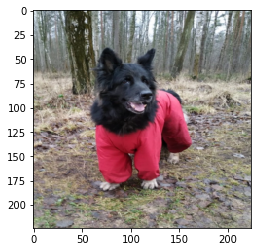

Hello, dog!
Your predicted breed is...
Belgian sheepdog
------------


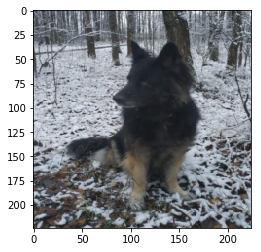

Hello, dog!
Your predicted breed is...
Belgian tervuren
------------


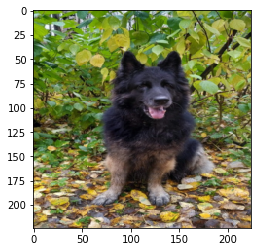

Hello, dog!
Your predicted breed is...
Belgian sheepdog
------------


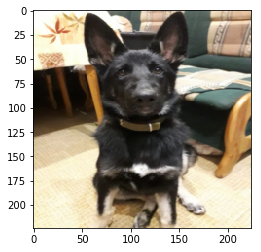

Hello, dog!
Your predicted breed is...
Belgian malinois
------------


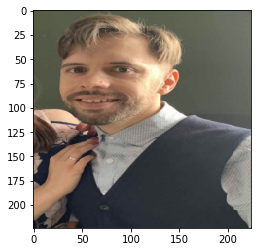

Hello, human!
You look like a...
Nova scotia duck tolling retriever
------------


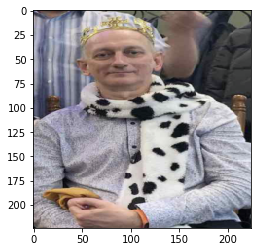

Hello, human!
You look like a...
Dalmatian
------------


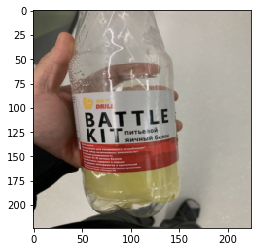

Hello, human!
You look like a...
Labrador retriever
------------


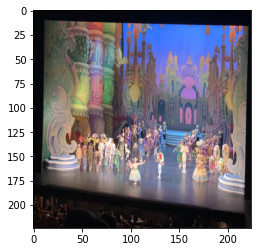

Hello, human!
You look like a...
Komondor
------------


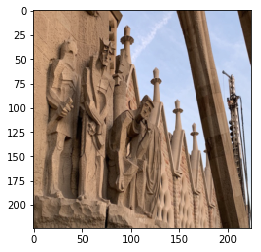

Error: Seems your image doesn't contain human face or a dog. Maybe it is a cat.
------------


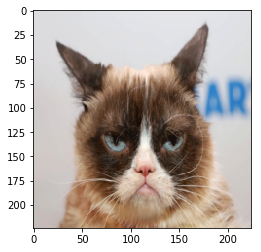

Hello, human!
You look like a...
Japanese chin
------------


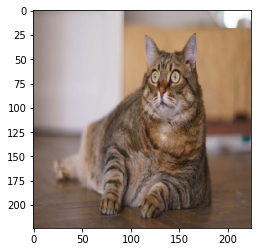

Error: Seems your image doesn't contain human face or a dog. Maybe it is a cat.
------------


In [86]:
for path in [
    "additional_files/dog1.1.jpg",
    "additional_files/dog1.2.jpg",
    "additional_files/dog1.3.jpg",
    "additional_files/dog2.jpg",
    "additional_files/human1.jpg",
    "additional_files/human2.jpg",
    "additional_files/other1.JPG",
    "additional_files/other2.JPG",
    "additional_files/other3.jpg",
    "additional_files/other4.jpg",
    "additional_files/other5.jpg",
]:
    run_app(path)
    print("------------")

Let's check where face detector detected faces in images which should be neither dog nor human: 

In [ ]:
for path in [
    "additional_files/other1.JPG",
    "additional_files/other2.JPG",
    "additional_files/other3.jpg",
    "additional_files/other4.jpg",
    "additional_files/other5.jpg",
]:
    plt.figure(figsize=(8,8))
    highlight_faces(path)
    print("------------")

Number of faces detected: 1


------------
Number of faces detected: 1


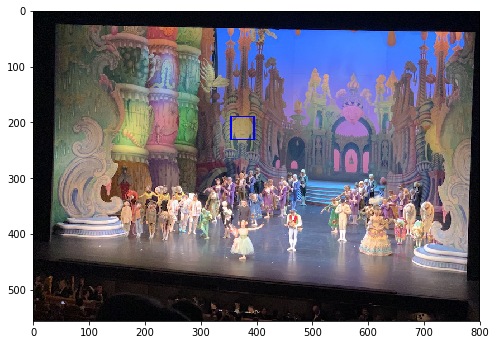

------------
Number of faces detected: 0


------------
Number of faces detected: 1


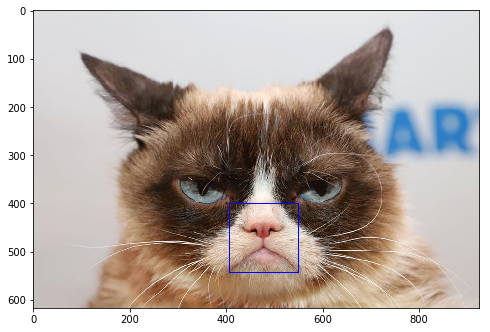

------------
Number of faces detected: 0


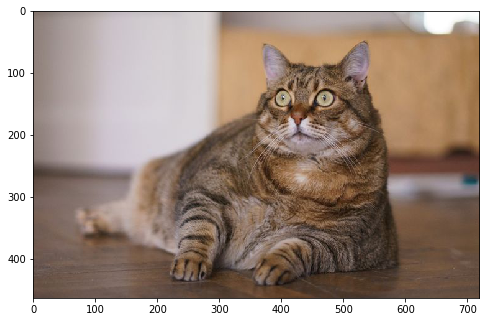

------------


In [85]:
for path in [
    "additional_files/other1.JPG",
    "additional_files/other2.JPG",
    "additional_files/other3.jpg",
    "additional_files/other4.jpg",
    "additional_files/other5.jpg",
]:
    plt.figure(figsize=(8,8))
    highlight_faces(path)
    print("------------")